# Домашнее задание
- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd
import numpy as np

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return    

### 1) Выберите ряд и постройте его модель ARIMA/GARCH.

In [10]:
auto_registration = pd.read_csv("monthly-us-auto-registration-tho.csv",sep=';')

In [11]:
auto_registration.head()

,Month,Monthly U.S. auto registration (thousands) 1947 ? 1968
0,1947-01,209
1,1947-02,214
2,1947-03,265
3,1947-04,290
4,1947-05,287


In [12]:
auto_registration=auto_registration.iloc[:,1]

Results of Dickey-Fuller Test:
Test Statistic                  -1.941628
p-value                          0.312738
#Lags Used                      14.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


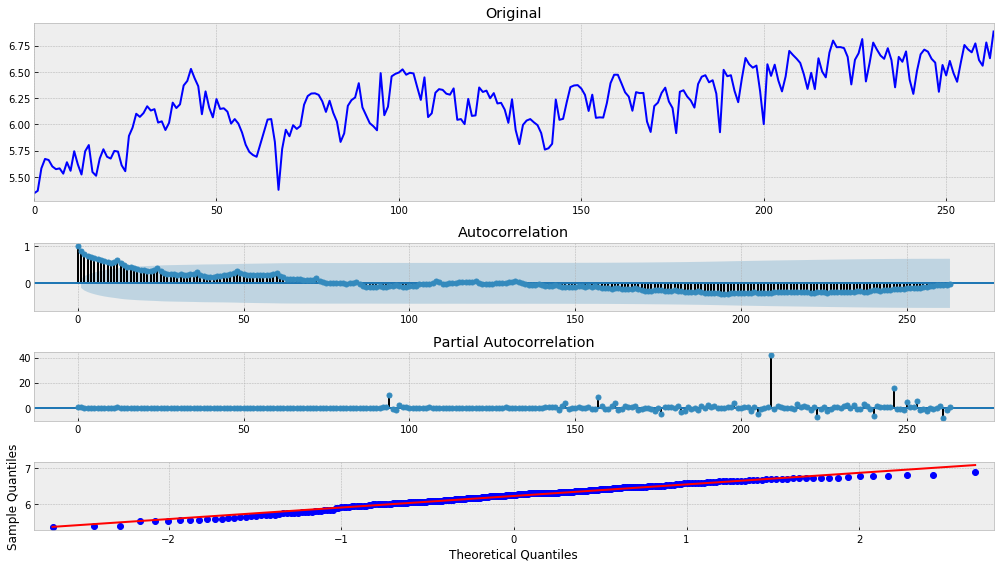

In [13]:
series=boxcox(auto_registration,0)
tsplot(series)

* имеем нестационарный ряд

In [14]:
train, val = series[:200], series[200:]

In [15]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(train)

aic: -201.82988 | order: (2, 1, 4)


Results of Dickey-Fuller Test:
Test Statistic                  -3.411208
p-value                          0.010583
#Lags Used                      12.000000
Number of Observations Used    186.000000
Critical Value (1%)             -3.466005
Critical Value (5%)             -2.877208
Critical Value (10%)            -2.575122
dtype: float64


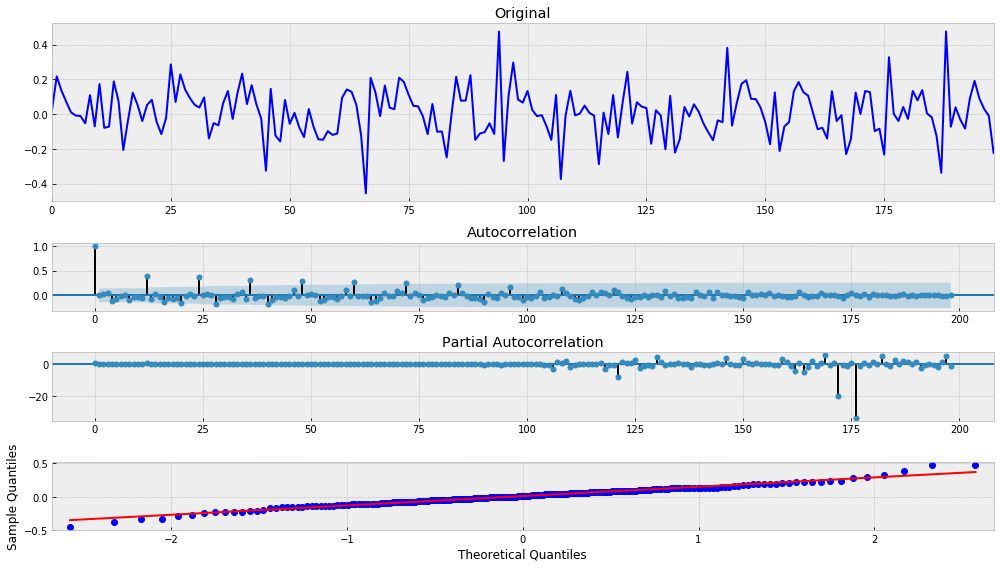

In [16]:
tsplot(mdl.resid)

* Я бы отверг гипотезу о стационарности ряда остатков, непохоже чтобы они были нормально распредлены

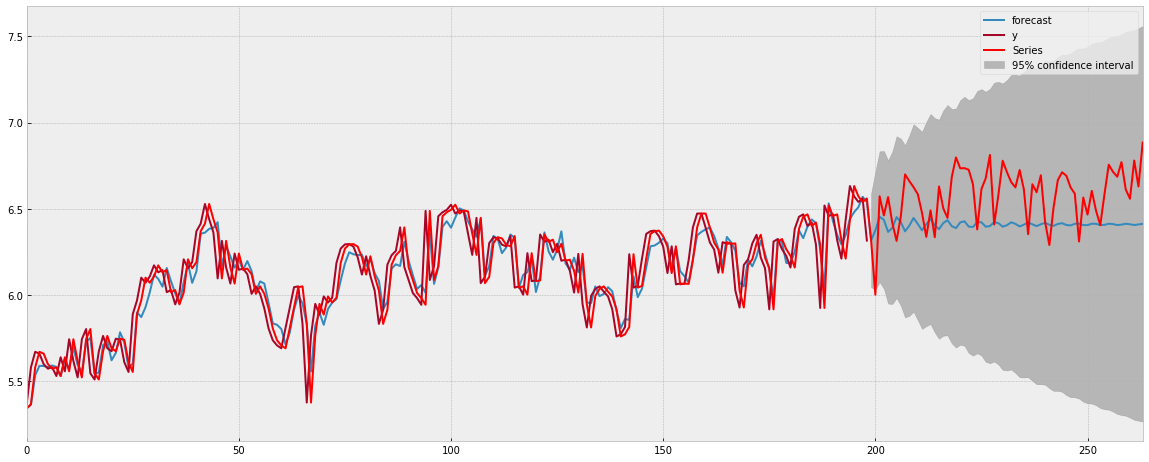

In [17]:
with plt.style.context('bmh'):
    plt.figure(figsize=(20,8))
    ax = plt.axes()
    mdl.plot_predict(1, len(series), ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

* Явно наш прогноз потерял дисперсию

In [20]:
from arch import arch_model

In [95]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(train, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.086
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.086
Vol Model:                        GJR-GARCH   Log-Likelihood:                24.2599
Distribution:      Standardized Student's t   AIC:                          -28.5197
Method:                  Maximum Likelihood   BIC:                           4.46346
                                              No. Observations:                  200
Date:                      Sat, May 18 2019   Df Residuals:                      190
Time:                              00:18:29   Df Model:                           10
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             6

Results of Dickey-Fuller Test:
Test Statistic                  -2.613863
p-value                          0.090166
#Lags Used                      12.000000
Number of Observations Used    187.000000
Critical Value (1%)             -3.465812
Critical Value (5%)             -2.877123
Critical Value (10%)            -2.575077
dtype: float64


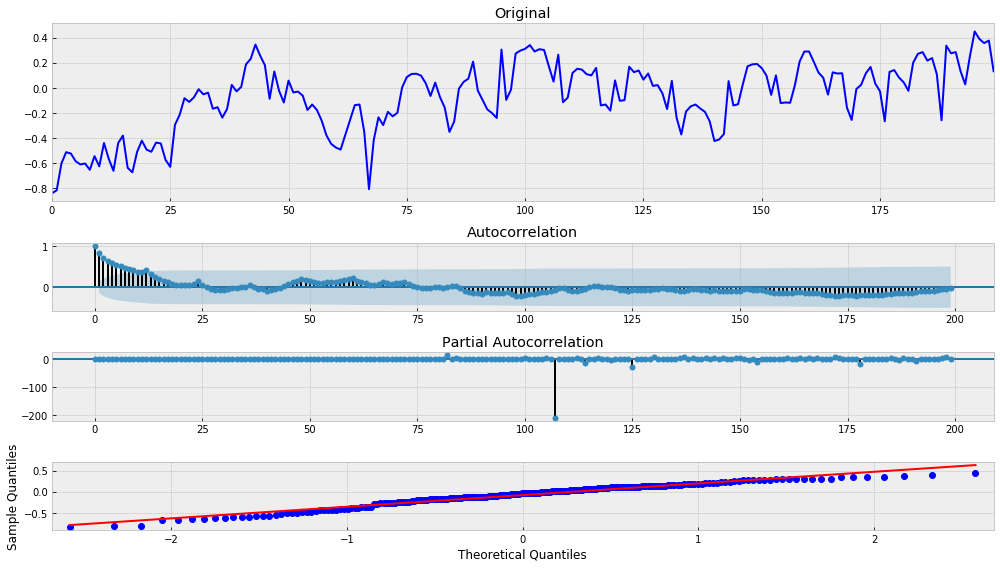

In [96]:
tsplot(res.resid)

* ряд остатков снова нестаонарен

In [100]:
yhat = res.forecast(horizon=len(val))

In [120]:
predicts=yhat.variance[-1:].values[0]

In [121]:
forecast=train.copy()
forecast=np.concatenate((forecast,predicts))

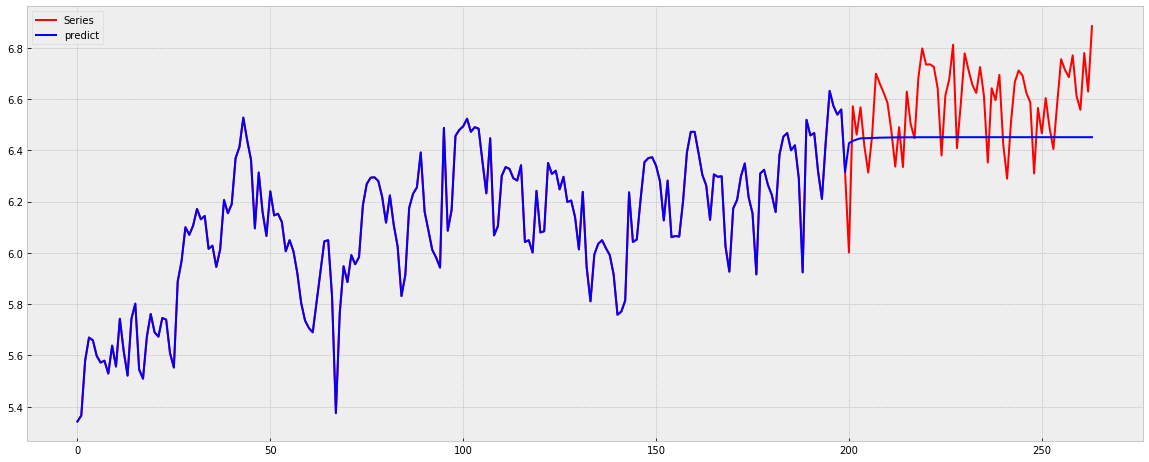

In [122]:
with plt.style.context('bmh'):
    plt.figure(figsize=(20,8))
    ax = plt.axes()
    #mdl.plot_predict(1, len(series), ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.plot(forecast, color='blue', label='predict')
    plt.legend()
    plt.show()

*  предсказания фактически в линию сваливаются, не оч хорошо

### 2) **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

In [24]:
series=auto_registration.to_frame(name='Count')

In [27]:
def prepareData(data, lag_start=1, lag_end=1, test_size=0.15):

    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    #print(test_index)
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        #print(data)
    data = data.dropna()
    data = data.reset_index(drop=True)
    #data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [28]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

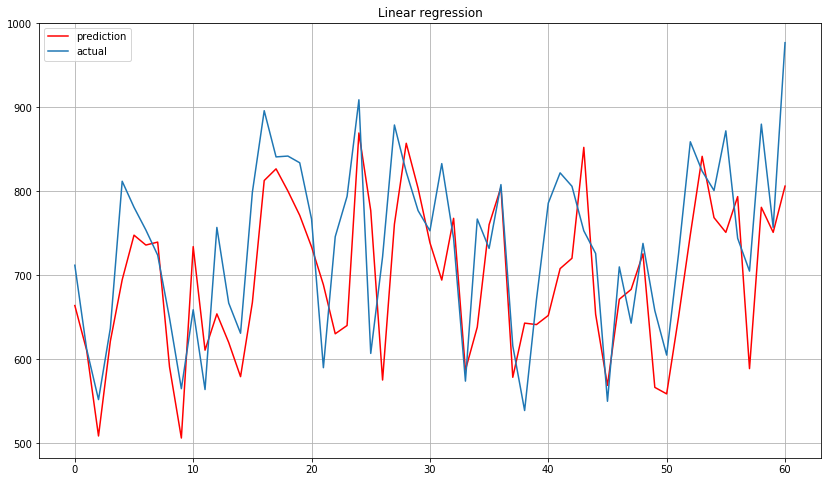

In [30]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
#plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

* Не слишком точно, но похоже получилось . Неожиданно лучше, чем все, что мы пробовали выше